In [ ]:
!pip install git+https://github.com/VincentStimper/normalizing-flows.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/VincentStimper/normalizing-flows.git to /tmp/pip-req-build-n1wxyzqw
  Running command git clone -q https://github.com/VincentStimper/normalizing-flows.git /tmp/pip-req-build-n1wxyzqw
  Cloning https://github.com/VincentStimper/residual-flows.git to /tmp/pip-install-zla8h78b/residual-flows_89f175c9080242dfbcfd8d25dacd64d9
  Running command git clone -q https://github.com/VincentStimper/residual-flows.git /tmp/pip-install-zla8h78b/residual-flows_89f175c9080242dfbcfd8d25dacd64d9
  Created wheel for normflow: filename=normflow-1.2-py2.py3-none-any.whl size=60862 sha256=5d47853b89c6a3741e06dfa9d1294b216e55e717693d5a651c647766fbc14909
  Stored in directory: /tmp/pip-ephem-wheel-cache-t26jzs_f/wheels/d9/40/c8/9ac98610e01d078086ad1abd95cd552ce5eef5bec50c647dd5
  Created wheel for residual-flows: filename=residual_flows-1.0-py2.py3-none-any.whl size=36203 sha256=2170a2

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import normflow as nf

# For plotting
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R
from scipy.stats import multivariate_normal

# For saving and loading
import pickle
%matplotlib inline

In [ ]:
K = 10
beta = 1.0
#torch.manual_seed(0)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

flows = []
for i in range(K):
    flows += [nf.flows.Planar((2,))]
target = nf.distributions.TwoModes(2, 0.1)

q0 = nf.distributions.DiagGaussian(2)
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target)
nfm.to(device)

NormalizingFlow(
  (q0): DiagGaussian()
  (flows): ModuleList(
    (0): Planar()
    (1): Planar()
    (2): Planar()
    (3): Planar()
    (4): Planar()
    (5): Planar()
    (6): Planar()
    (7): Planar()
    (8): Planar()
    (9): Planar()
  )
)

# NF Demo

In [ ]:
K = 32
beta = 1.0
#torch.manual_seed(0)

flows = []
for i in range(K):
    flows += [nf.flows.Planar((2,))]
target = nf.distributions.GaussianMixture(2, 2, scale=list(0.5*np.ones((2, 2))), trainable=False) #, loc=[[-2,-2], [-2,2], [2,2], [2,-2]], scale=[[0.7, 0.7], [0.7, 0.7], [0.7, 0.7], [0.7, 0.7]]

q0 = nf.distributions.DiagGaussian(2, trainable=False)
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target)
nfm.to(device)

NormalizingFlow(
  (q0): DiagGaussian()
  (flows): ModuleList(
    (0): Planar()
    (1): Planar()
    (2): Planar()
    (3): Planar()
    (4): Planar()
    (5): Planar()
    (6): Planar()
    (7): Planar()
    (8): Planar()
    (9): Planar()
    (10): Planar()
    (11): Planar()
    (12): Planar()
    (13): Planar()
    (14): Planar()
    (15): Planar()
    (16): Planar()
    (17): Planar()
    (18): Planar()
    (19): Planar()
    (20): Planar()
    (21): Planar()
    (22): Planar()
    (23): Planar()
    (24): Planar()
    (25): Planar()
    (26): Planar()
    (27): Planar()
    (28): Planar()
    (29): Planar()
    (30): Planar()
    (31): Planar()
  )
  (p): GaussianMixture()
)

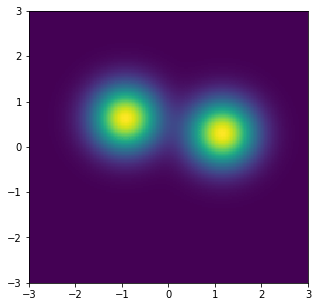

(32768, 2)
(32768, 2)


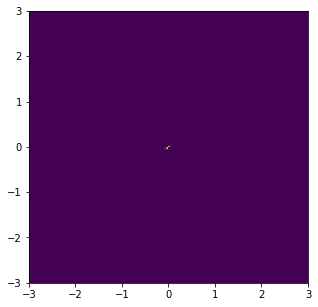

In [ ]:
# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
z = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
log_prob = target.log_prob(z.to(device)).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)

plt.figure(figsize=(5, 5))
plt.pcolormesh(xx, yy, prob)
plt.show()

# Plot initial posterior distribution
z, _ = nfm.sample(num_samples=2 ** 15)
z_np = z.to('cpu').data.numpy()
print(z_np.shape)
#z_np = np.random.multivariate_normal([0,0], [[0.1, 0], [0, 0.1]], 2 ** 15)
print(z_np[:,:2].shape)
plt.figure(figsize=(5, 5))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()

In [ ]:
class nfmodel(nn.Module):
    def __init__(self, q0=nf.distributions.DiagGaussian(9, trainable=False), flows=flows, p=target):
        super().__init__()

        self.q0 = q0
        self.flows = nn.ModuleList(flows)
        self.p = p

    def sample(self, num_samples=1):
        #z, log_q = torch.from_numpy(np.random.multivariate_normal([0,0], [[1, 0], [0, 1]], num_samples)), 0
        z, log_q = self.q0(num_samples)
        log_q = 0
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q


    def reverse_kld(self, num_samples=1, beta = beta):
        #z, log_q = torch.from_numpy(np.random.multivariate_normal([0,0], [[1, 0], [0, 1]], num_samples)), 0
        z, log_q = self.q0(num_samples)
        log_q = 0
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det

        log_p = self.p.log_prob(z)
        #log_p = 0
        #for block in z:
        #    log_p -= (torch.linalg.norm(block - torch.tensor([-2,-2]))**2 + torch.linalg.norm(block - torch.tensor([1,1]))**2)/(2*1)

        return torch.mean(log_q) - beta * torch.mean(log_p)


model = nfmodel(q0=q0, flows=flows, p=target).to(device)

 40%|███▉      | 1997/5000 [01:26<02:06, 23.73it/s]

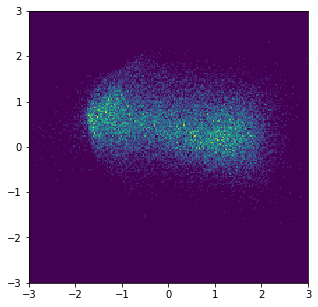

 80%|███████▉  | 3998/5000 [02:52<00:42, 23.54it/s]

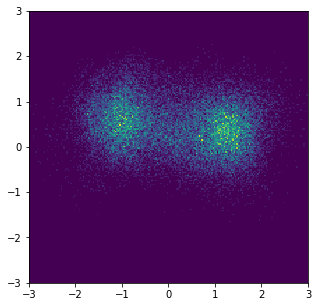

100%|██████████| 5000/5000 [03:35<00:00, 23.15it/s]


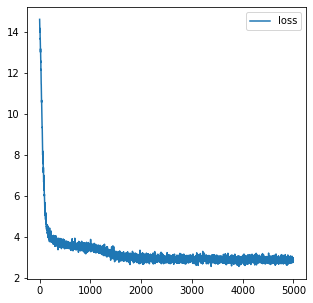

In [ ]:
# Train model
max_iter = 5000
num_samples = 100
anneal_iter = 10000
annealing = False
show_iter = 2000


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = model.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = model.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    # Plot learned posterior
    if ((it + 1) % show_iter == 0):
        torch.cuda.manual_seed(0)
        z, _ = model.sample(num_samples=2 ** 15)
        z_np = z.to('cpu').data.numpy()

        plt.figure(figsize=(5, 5))
        plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
        plt.show()

plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

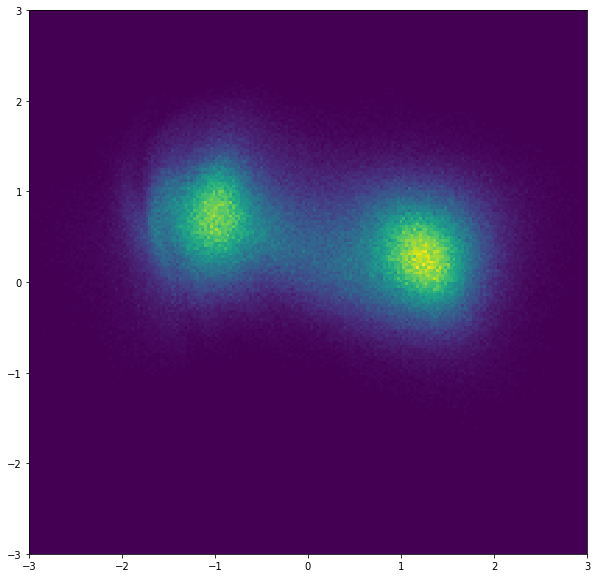

In [ ]:
# Plot learned posterior distribution
z, _ = model.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(10, 10))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()

# Load images

In [ ]:
# Frequently used definitions
dtype = torch.FloatTensor
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

pdbfile = 'water.pdb' #'alanine-dipeptide.pdb'
num_atoms = 3 #22
forcefile = 'amber14/tip3pfb.xml' #'amber14-all.xml'

pklfile = 'water_img1024_dim25_nse1_blob0.001_q0.2.pkl' #'aldip_img1024_dim51_nse1_scl0.001_q1.pkl'
num_imgs = 1000 #1024
n_cells = 25 #51
noise_var = 1
blob_var = 0.001
Q = 0.2

num_flows = 25
beta = 10.0
num_epochs = 1000

kB = 1.3807e-26
Avo = 6.0221408e+23
T = 300
kBxAvoxT = kB*Avo*T
print(kBxAvoxT)

noise_var_powk = noise_var ** (n_cells * n_cells)
print(noise_var_powk)

2.4944309407680003
1


In [ ]:
# Utility functions for putting gaussian blobs and Cryo-EM image plotting

def create_posmatrix(Q=Q, n_cells=n_cells):
    # Grids of x and y points
    x = torch.linspace(-Q, Q, n_cells, device=device)
    y = torch.linspace(-Q, Q, n_cells, device=device)
    # Create a 2-D meshgrid of (x, y) coordinates.
    x, y = torch.meshgrid(x, y, indexing='xy')

    # Creating mixture of gaussians
    pos = torch.empty(x.shape + (2,), device=device).double()
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    return pos

pos = create_posmatrix().type(dtype).to(device)
print(pos.is_cuda)

def torch_createblobs(coords, Q=Q, n_cells=n_cells, blob_var=blob_var, noise_var=0, rot_mat=None, pos=pos):
    new_coords = coords if rot_mat == None else coords @ rot_mat.T
    noise_matrix = 0 if noise_var == 0 else np.sqrt(noise_var)*torch.randn((n_cells, n_cells))
    normals = torch.zeros((n_cells, n_cells), device=device)

    for row in new_coords:
        normals += torch.exp(-(torch.norm(pos - row[0:2], dim=2)**2)/(2*(blob_var)))

    return normals/(np.sqrt(2*np.pi*blob_var)*len(new_coords)) + noise_matrix


def plot_cryoem_imgs(img_list, skip_by=1, Q=Q):
    for idx, img in enumerate(img_list):
        if idx % skip_by == 0:
            c = plt.imshow(img.cpu(), cmap ='gray', vmin = 0, vmax = np.abs(img.cpu()).max(),\
                            extent = [-Q, Q, -Q, Q], interpolation = 'nearest', origin = 'lower')
            plt.colorbar(c)

            plt.title(f'Cryo-EM Image {idx+1}', fontweight = "bold")
            plt.show()

print(device)

False
cpu


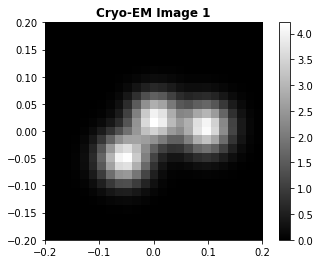

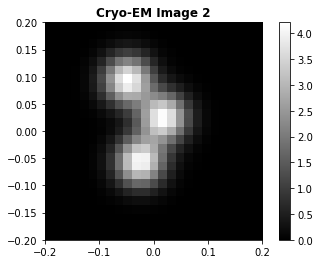

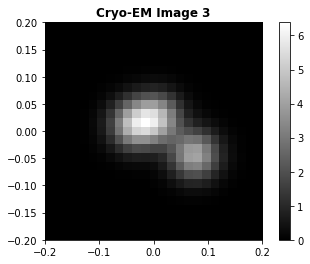

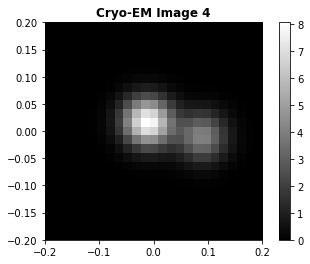

In [ ]:
with open(pklfile, 'rb') as inp:
    rot_mats = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]
    pot_energies = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]
    forces_list = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]
    pos_list = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]
    img_list = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]

plot_cryoem_imgs([torch_createblobs(pos_list[_]) for _ in range(4)], skip_by=1)
#print(torch.norm(img - img_list[idx])**2)
#print(pos_list[idx] @ rot_mats[idx].T)

# Experiments with Gaussian Blob plotting speed

In [ ]:
def create_fastpos(Q=Q, n_cells=n_cells):
    # Grids of x and y points
    x = torch.linspace(-Q, Q, n_cells, device=device)
    y = torch.linspace(-Q, Q, n_cells, device=device)
    # Create a 2-D meshgrid of (x, y) coordinates.
    x, y = torch.meshgrid(x, y, indexing='xy')

    # Creating mixture of gaussians
    pos = torch.empty(x.shape + (2,), device=device).double()
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    return torch.stack([pos]*num_atoms, dim = 3)

fpos = create_fastpos().type(dtype).to(device)

def torch_fastblobs(coords, Q=Q, n_cells=n_cells, blob_var=blob_var, noise_var=0, rot_mat=None, fpos=fpos):
    new_coords = coords if 0 else coords @ rot_mat.T
    noise_matrix = 0 if noise_var == 0 else np.sqrt(noise_var)*torch.randn((n_cells, n_cells))
    row_broadcast = new_coords[:, 0:2].T[None, None, :, :]

    normals = torch.exp(-(torch.norm(fpos - row_broadcast, dim=2)**2)/(2*(blob_var)))

    return torch.sum(normals, 2)/(np.sqrt(2*np.pi*blob_var)*len(new_coords)) + noise_matrix

In [ ]:
temp = torch.zeros((n_cells, n_cells, num_atoms))
temp[:,:,0] = torch.ones((n_cells, n_cells))
temp[:,:,1] = 2*torch.ones((n_cells, n_cells))
temp[:,:,2] = 3*torch.ones((n_cells, n_cells))

print(torch.transpose(fpos[0], 1, 2).shape)
print(fpos[0].shape)
b = torch.tensor([_ for _ in range(9)]).reshape((3,3))[:,0:2].T[None, None, :, :]
print(b.shape)

#temp = fpos + b
#print(torch.linalg.norm(temp, dim=2)[0])

torch.Size([25, 3, 2])
torch.Size([25, 2, 3])
torch.Size([1, 1, 2, 3])


In [ ]:
def create_fastestpos(Q=Q, n_cells=n_cells, n_imgs=num_imgs):
    # Grids of x and y points
    x = torch.linspace(-Q, Q, n_cells, device=device)
    y = torch.linspace(-Q, Q, n_cells, device=device)
    # Create a 2-D meshgrid of (x, y) coordinates.
    x, y = torch.meshgrid(x, y, indexing='xy')

    # Creating mixture of gaussians
    pos = torch.empty(x.shape + (2,), device=device).double()
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    intermediate = torch.stack([pos]*num_atoms, dim = 3)
    return torch.stack([intermediate]*num_imgs, dim = 0)

fstpos = create_fastestpos().type(dtype).to(device)

def torch_fastestblobs(coord_list, Q=Q, n_cells=n_cells, blob_var=blob_var, noise_var=0, rot_list=None, fstpos=fstpos):
    new_coords = coord_list if 0 else coord_list @ torch.transpose(rot_list, 1, 2)
    noise_matrix = 0 if noise_var == 0 else np.sqrt(noise_var)*torch.randn((n_cells, n_cells))
    row_broadcast = torch.transpose(new_coords[:, :, 0:2], 1, 2)[:, None, None, :, :]

    normals = torch.exp(-(torch.norm(fstpos - row_broadcast, dim=3)**2)/(2*(blob_var)))

    return torch.sum(normals, 3)/(np.sqrt(2*np.pi*blob_var)*len(new_coords)) + noise_matrix

In [ ]:
import time

start_time = time.time()
for idx in range(num_imgs):
    img = torch_createblobs(pos_list[idx], rot_mat=rot_mats[idx])
print("For createblobs: --- %s seconds ---" % (time.time() - start_time))

For createblobs: --- 0.5507032871246338 seconds ---


In [ ]:
start_time = time.time()
for idx in range(num_imgs):
    img = torch_fastblobs(pos_list[idx], rot_mat=rot_mats[idx])
print("For fastblobs: --- %s seconds ---" % (time.time() - start_time))

For fastblobs: --- 0.20197510719299316 seconds ---


In [ ]:
start_time = time.time()
temp = torch_fastestblobs(torch.stack(pos_list, dim = 0), rot_list=torch.stack(rot_mats, dim = 0))
print("For fastestblobs: --- %s seconds ---" % (time.time() - start_time))

For fastestblobs: --- 0.001867055892944336 seconds ---


In [ ]:
print(temp.shape)

torch.Size([64, 25, 25])


# Potential Energy calculations

In [ ]:
def potential(vec):
    eq_length, k_length = 0.101181082494, 462750.4
    eq_angle, k_angle = 1.88754640288, 836.8

    bond1 = vec[0:3] - vec[3:6]
    bond2 = vec[0:3] - vec[6:9]

    bond_pot = k_length*((eq_length - torch.norm(bond1))**2 + (eq_length - torch.norm(bond2))**2)
    angle_pot = k_angle*(eq_angle - torch.acos(torch.dot(bond1, bond2)/(torch.norm(bond1)*torch.norm(bond2))))**2

    return angle_pot + bond_pot


def potential_fast(coord_list):
    eq_length, k_length = 0.101181082494, 462750.4
    eq_angle, k_angle = 1.88754640288, 836.8

    bond1 = coord_list[:, 0, :] - coord_list[:, 1, :] #vec[0:3] - vec[3:6]
    bond2 = coord_list[:, 0, :] - coord_list[:, 2, :] #vec[0:3] - vec[6:9]

    bond_pot = k_length*((eq_length - torch.norm(bond1, dim = 1))**2 + (eq_length - torch.norm(bond2, dim = 1))**2)
    angle_pot = k_angle*(eq_angle - torch.acos(torch.bmm(bond1[:, None, :], bond2[:, :, None])[:,0,0]/(torch.norm(bond1, dim = 1)*torch.norm(bond2, dim = 1))))**2

    return angle_pot + bond_pot


atm_crd = np.array([[-0.01907088,-0.03568486,0.02280679], [0.03153054,0.04458783,0.05792664], [0.01212991,-0.05448926,-0.07158886]])
print(potential(torch.tensor(atm_crd.flatten())))
atm_crd = np.array([[-0.0193,-0.0359,0.0220], [0.0319,0.0440,0.0570], [0.0128,-0.0549,-0.0666]])
print(potential(torch.tensor(atm_crd.flatten())))

atm_crd = np.array([[[-0.01907088,-0.03568486,0.02280679], [0.03153054,0.04458783,0.05792664], [0.01212991,-0.05448926,-0.07158886]],
                    [[-0.0193,-0.0359,0.0220], [0.0319,0.0440,0.0570], [0.0128,-0.0549,-0.0666]]])
print(potential_fast(torch.tensor(atm_crd)))

tensor(0.0288, dtype=torch.float64)
tensor(11.8249, dtype=torch.float64)
tensor([ 0.0288, 11.8249], dtype=torch.float64)


# Cryo-EM experiments with no images

### Gaussian Base

In [ ]:
'''
with open(pklfile, 'rb') as inp:
    rot_mats = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]
    pot_energies = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]
    forces_list = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]
    pos_list = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]
    img_list = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]

plot_cryoem_imgs(img_list[:2])'''

"\nwith open(pklfile, 'rb') as inp:\n    rot_mats = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]\n    pot_energies = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]\n    forces_list = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]\n    pos_list = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]\n    img_list = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]\n\nplot_cryoem_imgs(img_list[:2])"

In [ ]:
count = 100
loc = [pos_list[i].flatten().cpu().numpy() for i in range(count)]
print(loc[0].shape)

num_flows = 200
flows = []
for i in range(num_flows):
    flows += [nf.flows.Planar((num_atoms*3,), u=torch.zeros(num_atoms*3), b=torch.zeros(1))]

q0 = nf.distributions.DiagGaussian(num_atoms*3, trainable=False)
target = nf.distributions.GaussianMixture(count, num_atoms*3, loc=loc, scale=list(0.5*np.ones((count, num_atoms*3))), trainable=False)

(9,)


In [ ]:
class nfmodel(nn.Module):
    def __init__(self, q0=q0, flows=flows, p=target):
        super().__init__()

        self.q0 = q0
        self.flows = nn.ModuleList(flows)
        self.p = p

    def sample(self, num_samples=1):
        #z, log_q = torch.from_numpy(np.random.multivariate_normal([0,0], [[1, 0], [0, 1]], num_samples)), 0
        z, log_q = self.q0(num_samples)
        log_q = 0
        z = z/100
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q


    def reverse_kld(self, num_samples=1, beta = beta):
        #z, log_q = torch.from_numpy(np.random.multivariate_normal([0,0], [[1, 0], [0, 1]], num_samples)), 0
        z, log_q = self.q0(num_samples)
        log_q = 0
        z = z/100
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det

        log_p = self.p.log_prob(z)
        log_pot = potential_fast(z.reshape(-1, num_atoms, num_atoms))  # torch.tensor([0.]) #
        #log_p = 0
        #for block in z:
        #    log_p -= (torch.linalg.norm(block - torch.tensor([-2,-2]))**2 + torch.linalg.norm(block - torch.tensor([1,1]))**2)/(2*1)

        return torch.mean(log_q) - torch.mean(log_p) + torch.mean(log_pot) / (beta * kBxAvoxT)


model = nfmodel(q0=q0, flows=flows, p=target).to(device)

In [ ]:
# Train model
max_iter = 5000
num_samples = 100
anneal_iter = 10000
annealing = False
show_iter = max_iter/20


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = model.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = model.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    if it % show_iter == 0:
        print(f' Loss: {loss_hist[-1]}')

    # Plot learned posterior
    #if ((it + 1) % show_iter == 0):
    #    torch.cuda.manual_seed(0)
    #    z, _ = model.sample(num_samples=2 ** 15)
    #    z_np = z.to('cpu').data.numpy()

    #    plt.figure(figsize=(5, 5))
    #    plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
    #    plt.show()

plt.figure(figsize=(5, 5))
plt.plot(loss_hist[int(max_iter/2):], label='loss')
plt.legend()
plt.show()

  0%|          | 2/5000 [00:00<16:21,  5.09it/s]

 Loss: 75.37595536492863


  5%|▌         | 252/5000 [00:49<15:10,  5.21it/s]

 Loss: 66.11737923941874


 10%|█         | 502/5000 [01:39<14:34,  5.14it/s]

 Loss: 53.607972858142986


 15%|█▌        | 752/5000 [02:29<13:52,  5.10it/s]

 Loss: 38.47002849261952


 20%|██        | 1001/5000 [03:18<13:00,  5.13it/s]

 Loss: 21.306458098053803


 20%|██        | 1018/5000 [03:22<13:10,  5.04it/s]


KeyboardInterrupt: ignored

tensor([[ 0.0264, -0.0607, -0.0231],
        [-0.0450, -0.0578,  0.0543],
        [ 0.0185,  0.1185, -0.0312]], grad_fn=<SubBackward0>)
tensor(0.1054, grad_fn=<CopyBackwards>)
tensor(0.1796, grad_fn=<CopyBackwards>)
tensor(0.2060, grad_fn=<CopyBackwards>)


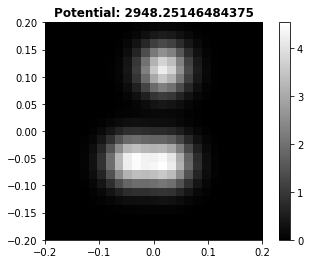

In [ ]:
molecules, _ = model.sample(num_samples=1)
molecule = torch.mean(molecules, dim = 0)

atm_crd = molecule.reshape(num_atoms,3)
print(atm_crd - torch.mean(atm_crd, dim = 0))
print(torch.norm(atm_crd[0] - atm_crd[1]))
print(torch.norm(atm_crd[0] - atm_crd[2]))
print(torch.norm(atm_crd[1] - atm_crd[2]))

img = torch_createblobs(atm_crd - torch.mean(atm_crd, dim = 0)).data  #, rot_mat=rot_mats[idx]
c = plt.imshow(img.cpu(), cmap ='gray', vmin = 0, vmax = np.abs(img.cpu()).max(),\
                          extent = [-Q,Q,-Q,Q], interpolation = 'nearest', origin = 'lower')
plt.colorbar(c)

#print(torch.norm(torch.tensor(img) - img_list[idx]))
plt.title(f'Potential: {potential(molecule.flatten())}', fontweight = "bold")
plt.show()

## With MD Base

In [ ]:
count = 1
loc = [pos_list[i].flatten().cpu().numpy() for i in range(count)]

num_flows = 10
flows = []
for i in range(num_flows):
    flows += [nf.flows.Planar((num_atoms*3,), u=torch.zeros(num_atoms*3), b=torch.zeros(1))]

q0 = nf.distributions.DiagGaussian(num_atoms*3, trainable=False)
target = nf.distributions.GaussianMixture(count, num_atoms*3, loc=loc, scale=list(0.05 * np.ones((count, num_atoms*3))), trainable=False)

In [ ]:
class nfmodel(nn.Module):
    def __init__(self, q0=q0, flows=flows, p=target):
        super().__init__()

        self.q0 = torch.vstack([i.reshape(-1, num_atoms*3) for i in pos_list]) 
        self.flows = nn.ModuleList(flows)
        self.p = p

    def sample(self, num_samples=1):
        rand_idx = np.random.randint(low=count, high=len(pos_list), size=num_samples)
        z, log_q = self.q0[rand_idx], 0

        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q


    def reverse_kld(self, num_samples=1, beta = beta):
        rand_idx = np.random.randint(low=count, high=len(pos_list), size=num_samples)
        z, log_q = self.q0[rand_idx], 0

        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det

        log_p = self.p.log_prob(z)
        log_pot = potential_fast(z.reshape(-1, num_atoms, num_atoms))  #torch.tensor([0.]) # 
        #log_p = 0
        #for block in z:
        #    log_p -= (torch.linalg.norm(block - torch.tensor([-2,-2]))**2 + torch.linalg.norm(block - torch.tensor([1,1]))**2)/(2*1)

        return torch.mean(log_q) - torch.mean(log_p) + torch.mean(log_pot) / (beta * kBxAvoxT)


model = nfmodel(q0=q0, flows=flows, p=target).to(device)

In [ ]:
# Train model
max_iter = 2500
num_samples = 50
anneal_iter = 10000
annealing = False

loss_hist = []

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = model.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = model.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
        
    loss_hist.append(loss.to('cpu').data.numpy())
    if it % int(max_iter/10) == 0:
        print(loss_hist[-1])

plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

  0%|          | 10/2500 [00:00<00:26, 94.62it/s]

-9.618650883664834


 11%|█         | 265/2500 [00:02<00:24, 92.88it/s]

-19.36708327000384


 21%|██        | 517/2500 [00:05<00:24, 80.48it/s]

-19.298217084525533


 31%|███       | 763/2500 [00:08<00:20, 85.68it/s]

-19.269754977266288


 40%|███▉      | 992/2500 [00:11<00:17, 88.70it/s]


KeyboardInterrupt: ignored

tensor([[-0.0382,  0.0351,  0.0334],
        [ 0.0456, -0.0555,  0.0351],
        [-0.0073,  0.0204, -0.0685]], grad_fn=<SubBackward0>)
tensor(0.1235, grad_fn=<CopyBackwards>)
tensor(0.1075, grad_fn=<CopyBackwards>)
tensor(0.1389, grad_fn=<CopyBackwards>)


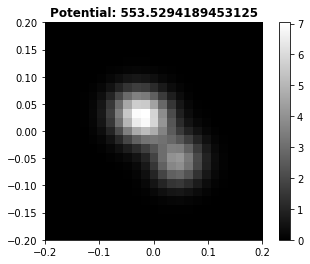

In [ ]:
molecules, _ = model.sample(num_samples=1)
molecule = torch.mean(molecules, dim = 0)

atm_crd = molecule.reshape(num_atoms,3)
print(atm_crd - torch.mean(atm_crd, dim = 0))
print(torch.norm(atm_crd[0] - atm_crd[1]))
print(torch.norm(atm_crd[0] - atm_crd[2]))
print(torch.norm(atm_crd[1] - atm_crd[2]))

img = torch_createblobs(atm_crd - torch.mean(atm_crd, dim = 0)).data  #, rot_mat=rot_mats[idx]
c = plt.imshow(img.cpu(), cmap ='gray', vmin = 0, vmax = np.abs(img.cpu()).max(),\
                          extent = [-Q,Q,-Q,Q], interpolation = 'nearest', origin = 'lower')
plt.colorbar(c)

#print(torch.norm(torch.tensor(img) - img_list[idx]))
plt.title(f'Potential: {potential(molecule.flatten())}', fontweight = "bold")
plt.show()

# Create Cryo-EM torch images

In [ ]:
# Generate rotation matrices
num_imgs = 1024

rot_mats = []
for n in range(num_imgs):
    r = R.from_euler('zyx', [[np.random.uniform(0, 2*np.pi), np.random.uniform(0, np.pi), np.random.uniform(0, 2*np.pi)]],
                     degrees=False)
    rot_mats.append(torch.tensor(r.as_matrix()[0]).type(dtype))

In [ ]:
pot_energies = []
forces_list = []
pos_list = []
img_list = []

for i in range(num_imgs):
    if i%64 == 0:
        print(f'Starting step: {i}...')
    
    simulation.step(1000)
    state0 = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
    temp_pos = state0.getPositions(asNumpy=True)
    simulation.context.setPositions(temp_pos - temp_pos.mean())

    pot_energies.append(torch.tensor(state0.getPotentialEnergy()._value).type(dtype))
    pos_list.append(torch.tensor(state0.getPositions(asNumpy=True)._value).type(dtype))
    forces_list.append(torch.tensor(state0.getForces(asNumpy=True)._value).type(dtype))
    img_list.append(torch_createblobs(pos_list[-1], Q=0.2, n_cells=25, blob_var=0.0005, noise_var=100, rot_mat=rot_mats[i]))

Starting step: 0...
Starting step: 64...
Starting step: 128...
Starting step: 192...
Starting step: 256...
Starting step: 320...
Starting step: 384...
Starting step: 448...
Starting step: 512...
Starting step: 576...
Starting step: 640...
Starting step: 704...
Starting step: 768...
Starting step: 832...
Starting step: 896...
Starting step: 960...


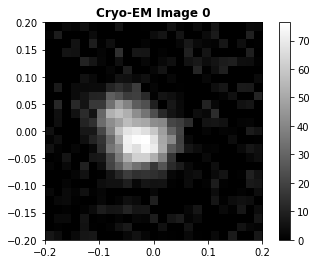

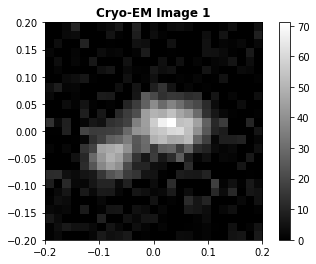

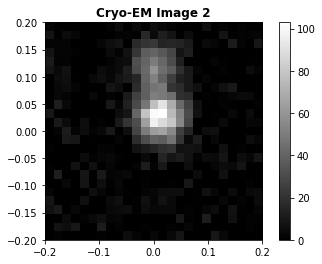

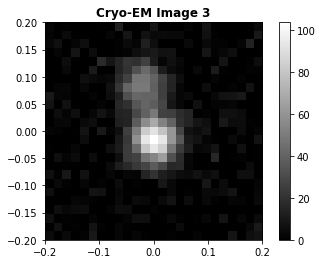

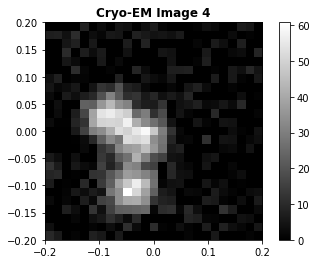

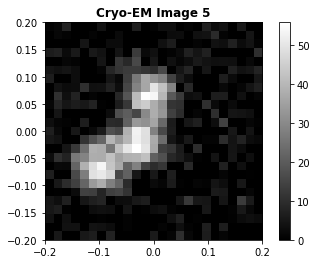

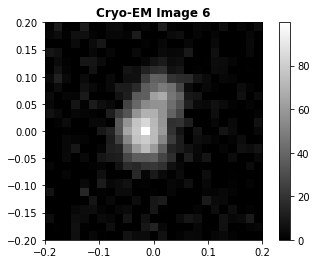

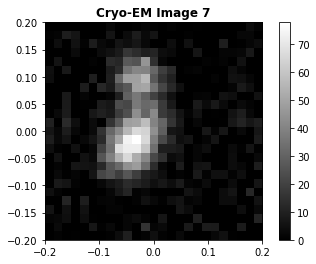

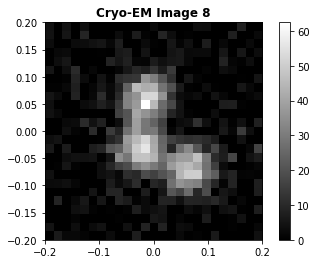

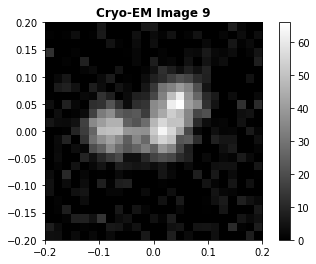

In [ ]:
for idx, img in enumerate(img_list):
    if idx in [i for i in range(10)]:
        c = plt.imshow(img, cmap ='gray', vmin = 0, vmax = np.abs(img).max(),\
                          extent = [-0.2, 0.2, -0.2, 0.2], interpolation = 'nearest', origin = 'lower')
        plt.colorbar(c)
                
        plt.title(f'Cryo-EM Image {idx}', fontweight = "bold")
        plt.show()

In [ ]:
with open('water_img1024_dim25_nse100_blob0.0005_q0.2.pkl', 'wb') as outp:
    pickle.dump(rot_mats, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(pot_energies, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(forces_list, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(pos_list, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(img_list, outp, pickle.HIGHEST_PROTOCOL)

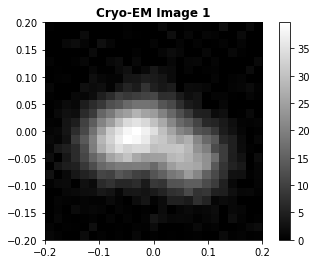

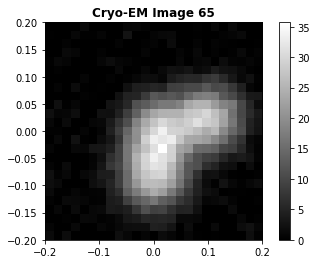

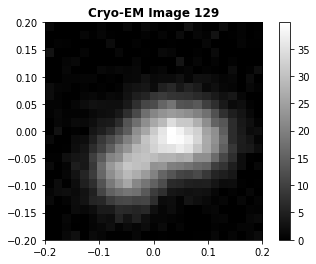

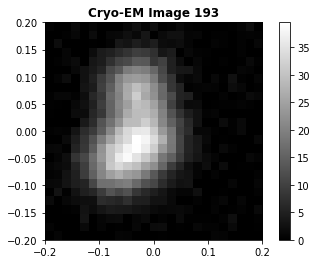

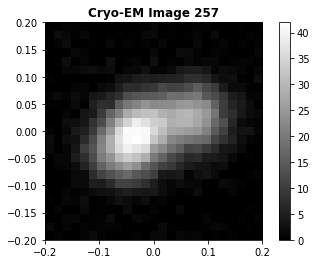

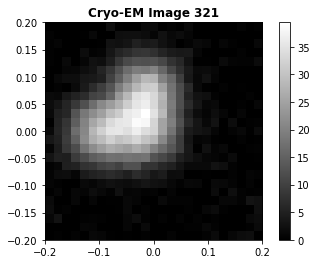

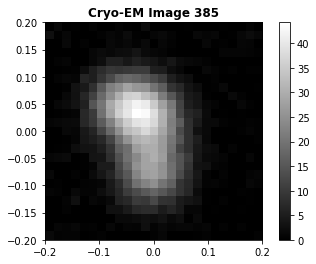

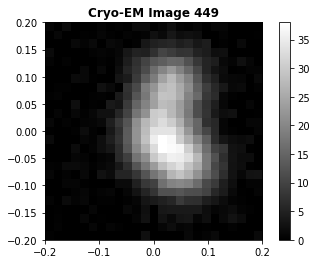

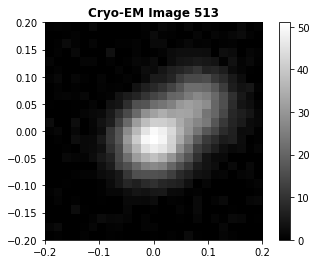

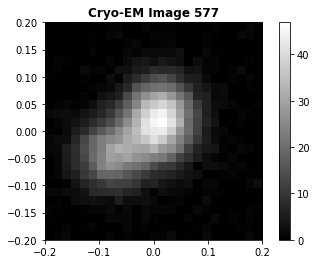

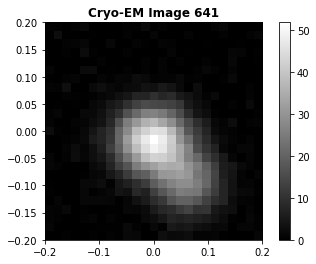

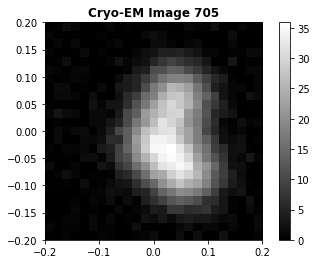

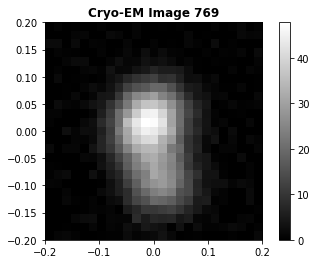

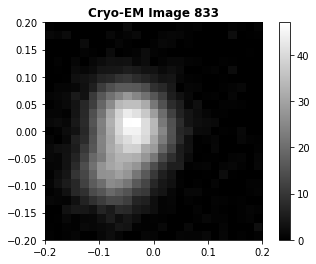

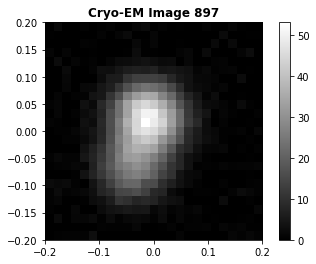

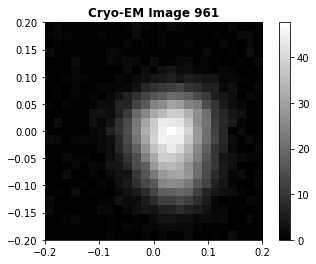

In [ ]:
with open('water_img1024_dim25_nse1_blob0.002_q0.2.pkl', 'rb') as inp:
    rot_mats = pickle.load(inp)[0:num_imgs]
    pot_energies = pickle.load(inp)[0:num_imgs]
    forces_list = pickle.load(inp)[0:num_imgs]
    pos_list = pickle.load(inp)
    img_list = pickle.load(inp)[0:num_imgs]

for idx, img in enumerate(img_list):
    if idx % 64 == 0:
        c = plt.imshow(img, cmap ='gray', vmin = 0, vmax = np.abs(img).max(),\
                        extent = [-Q, Q, -Q, Q], interpolation = 'nearest', origin = 'lower')
        plt.colorbar(c)

        plt.title(f'Cryo-EM Image {idx+1}', fontweight = "bold")
        plt.show()

# MD Simulated latent vectors

In [ ]:
pos_list = []

for i in range(1000000):
    if i%1000 == 0:
        print(f'Starting step: {i}...')
    
    simulation.step(100)
    state0 = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
    temp_pos = state0.getPositions(asNumpy=True)
    simulation.context.setPositions(temp_pos - temp_pos.mean())
    pos_list.append(torch.tensor(state0.getPositions(asNumpy=True)._value).type(dtype))

Starting step: 0...
Starting step: 1000...
Starting step: 2000...
Starting step: 3000...
Starting step: 4000...
Starting step: 5000...
Starting step: 6000...
Starting step: 7000...
Starting step: 8000...
Starting step: 9000...
Starting step: 10000...
Starting step: 11000...
Starting step: 12000...
Starting step: 13000...
Starting step: 14000...
Starting step: 15000...
Starting step: 16000...
Starting step: 17000...
Starting step: 18000...
Starting step: 19000...
Starting step: 20000...
Starting step: 21000...
Starting step: 22000...
Starting step: 23000...
Starting step: 24000...
Starting step: 25000...
Starting step: 26000...
Starting step: 27000...
Starting step: 28000...
Starting step: 29000...
Starting step: 30000...
Starting step: 31000...
Starting step: 32000...
Starting step: 33000...
Starting step: 34000...
Starting step: 35000...
Starting step: 36000...
Starting step: 37000...
Starting step: 38000...
Starting step: 39000...
Starting step: 40000...
Starting step: 41000...
Start

In [ ]:
with open('water_pos1M_q0.2.pkl', 'wb') as outp:
    pickle.dump(pos_list, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
print(pos_list[:12])

[tensor([[-0.0022,  0.0187,  0.0200],
        [-0.0274, -0.0780,  0.0357],
        [ 0.0448,  0.0332, -0.0684]]), tensor([[ 0.0053,  0.0210,  0.0160],
        [-0.0959,  0.0190,  0.0174],
        [ 0.0459, -0.0584,  0.0638]]), tensor([[-0.0026,  0.0058,  0.0142],
        [ 0.0794,  0.0621, -0.0043],
        [-0.0727,  0.0737,  0.0408]]), tensor([[-0.0268, -0.0029, -0.0074],
        [-0.0627, -0.0872,  0.0355],
        [ 0.0607, -0.0289, -0.0511]]), tensor([[ 0.0006,  0.0083,  0.0116],
        [-0.0310,  0.0879, -0.0423],
        [-0.0723, -0.0433,  0.0592]]), tensor([[-0.0096,  0.0128,  0.0129],
        [ 0.0401, -0.0595,  0.0634],
        [ 0.0613,  0.0742, -0.0252]]), tensor([[-0.0149, -0.0075, -0.0031],
        [-0.0515,  0.0679, -0.0599],
        [-0.0974, -0.0631,  0.0154]]), tensor([[-0.0024,  0.0206,  0.0148],
        [-0.0166, -0.0707,  0.0561],
        [ 0.0886,  0.0565,  0.0406]]), tensor([[-0.0153, -0.0066,  0.0015],
        [ 0.0056,  0.0904, -0.0180],
        [-0.0982, -0.